<a href="https://colab.research.google.com/github/SathyaSudha-96/TorchIO/blob/main/3D_UNet_TorchIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TorchIO Installation**
---

In [1]:
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.48

     |████████████████████████████████| 151 kB 8.2 MB/s 
     |████████████████████████████████| 48.4 MB 5.1 kB/s 


**Loading required libraries**

---



In [2]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.manual_seed(0)

**Loading IXITiny Dataset using torchIO**

In [4]:
datasets = tio.datasets.IXITiny('content/drive/MyDrive/IXI_TorchIO/',download = True)

Root directory for IXITiny not found: content/drive/MyDrive/IXI_TorchIO
Downloading...


0it [00:00, ?it/s]

In [5]:
print('Dataset size:', len(datasets), 'subjects')
print(datasets[0])
print(datasets[0].image)
print(datasets[0].label)

Dataset size: 566 subjects
Subject(Keys: ('image', 'label', 'subject_id'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 392.3 KiB; dtype: torch.ShortTensor)
LabelMap(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 196.2 KiB; dtype: torch.ByteTensor)


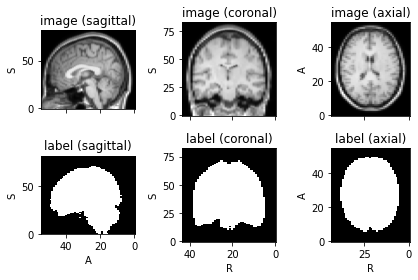

In [6]:
datasets[0].plot()

Functions for Degradation and Preprocessing

In [7]:
Noisy_transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(std = 0.5),
    #tio.RandomMotion(p = 0.3),
    tio.RandomBlur(p = 0.8),
    tio.OneHot(),
])

transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])
print(len(datasets))

566


In [8]:
Real_set = tio.SubjectsDataset(
    datasets, transform=transform)

Noisy_set = tio.SubjectsDataset(
   datasets , transform=Noisy_transform)

print('Real set:', len(Real_set), 'subjects')
print('Noisy set:', len(Noisy_set), 'subjects')

Real set: 566 subjects
Noisy set: 566 subjects


In [9]:
Real_train, Real_test, Noisy_train, Noisy_test = train_test_split(np.array(Real_set), np.array(Noisy_set), test_size=200, shuffle=True)
#Real_train , Real_test = torch.utils.data.random_split((Real_set,(400,166))
#Noisy_train , Noisy_test = torch.utils.data.random_split(Noisy_set,(400,166))

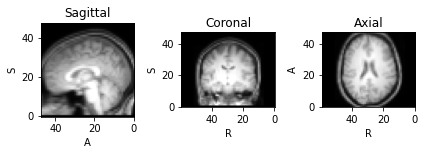

In [10]:
Real_set[3].image.plot()

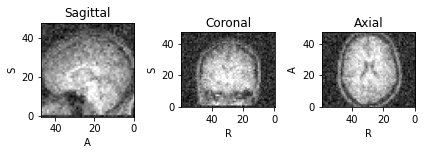

In [11]:
Noisy_set[3].image.plot()

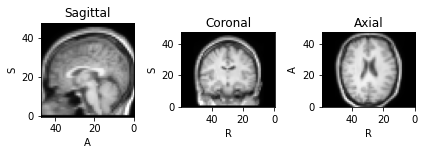

In [12]:
Real_train[3].image.plot()

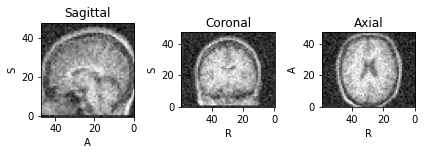

In [13]:
Noisy_train[3].image.plot()

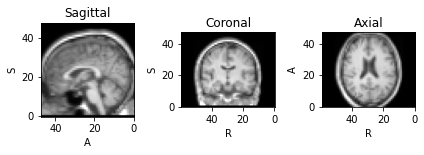

In [14]:
Real_test[1].image.plot()

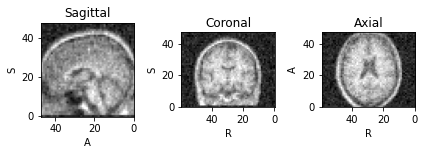

In [15]:
Noisy_test[1].image.plot()

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
def prepare_batch(x,y, device):
    inputs = x['image'][tio.DATA].to(device)
    targets = y['image'][tio.DATA].to(device)
    return inputs, targets

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=1,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

**Dataloaders**

---



In [17]:
Noisy__train_loader = torch.utils.data.DataLoader(Noisy_train,batch_size=32,shuffle=False)
Real__train_loader = torch.utils.data.DataLoader(Real_train,batch_size=32,shuffle=False)
Noisy_test_loader = torch.utils.data.DataLoader(Noisy_test,batch_size=32,shuffle=False)
Real_test_loader = torch.utils.data.DataLoader(Real_test,batch_size=32,shuffle=False)

In [18]:
model, optimizer = get_model_and_optimizer(device)
loss = nn.MSELoss()
epochs = 10
print(model)

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): PReLU(num_parameters=1)
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (norm_layer): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation_layer): PReLU(num_parameters=1)
          (block): Sequential(
            (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [19]:
for epoch in range(epochs):
  is_training = True
  epoch_losses = []
  times = []
  model.train(is_training)
  for batch_idx, (X,Y) in enumerate(zip(tqdm(Noisy__train_loader), Real__train_loader)):
    inputs, targets = prepare_batch(X,Y, device)
    #print('Input',inputs.shape)
    #print('Actual output',targets.shape)
    optimizer.zero_grad()
    with torch.set_grad_enabled(is_training):
      logits = model(inputs)
      #print('Predicted Output',logits.shape)
      probabilities = F.softmax(logits, dim=1)
      #print('probability',probabilities.shape)
      batch_losses = loss(logits, targets)
      batch_loss = batch_losses.mean()
      #print('Batch Loss Mean',batch_loss)
      if is_training:
        batch_loss.backward()
        optimizer.step()
        times.append(time.time())
        epoch_losses.append(batch_loss.item())
  epoch_losses = np.array(epoch_losses)
  print(f'mean loss: {epoch_losses.mean():0.3f}')

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


mean loss: 2.046


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 1.384


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 1.067


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.823


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.629


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.477


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.357


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.266


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.198


  0%|          | 0/12 [00:00<?, ?it/s]

mean loss: 0.147


**Save the Model**

---



In [20]:
torch.save(model.state_dict(), '/content/drive/MyDrive/IXI_TorchIO/3dUNet.pth')

**Validation**

---



In [21]:
a = next(iter(Noisy_test_loader))
b = next(iter(Real_test_loader))
model.eval()
inputs, targets = prepare_batch(a,b, device)
with torch.no_grad():
    p = model(inputs)
    l = loss(p,targets)
    print('Validation Loss',l)

Validation Loss tensor(0.1528)


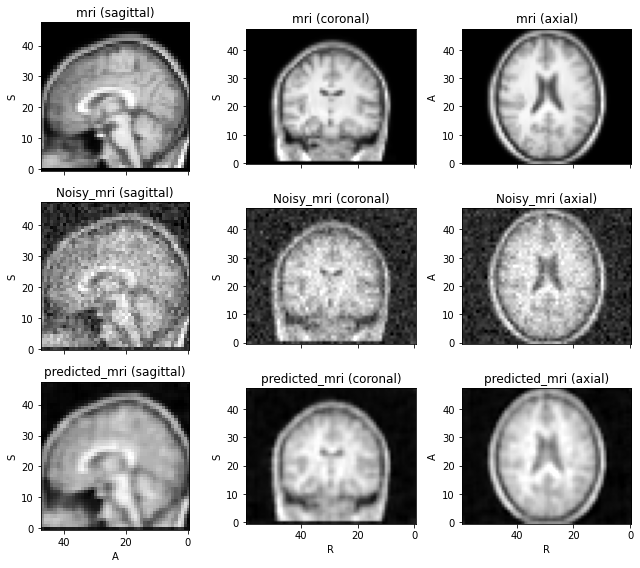

In [22]:
affine = a['image'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=b['image'][tio.DATA][2], affine=affine),
    Noisy_mri = tio.ScalarImage(tensor = a['image'][tio.DATA][2], affine=affine),
    predicted_mri=tio.ScalarImage(tensor=p[2], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'gray'})